In [4]:
import numpy as np
import xarray as xr
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('./grl.mplstyle')

%load_ext autoreload
%autoreload 3

DATAPATH = '/scratch/jw8736/ctr/outputs/'

In [47]:
l_nu = (2*np.pi-1)/720
t_nu = l_nu/0.25
print(t_nu)
print(0.1/t_nu)

0.029351029484331034
170.3517759971328


In [5]:
def plot_log(z, u, ax, kwargs={}):
    
    zwall = (2*np.pi-1)/720.
    ustar = 0.25

    l = plt.plot(z/zwall, u/ustar, **kwargs)

    ax.axvline(x=0.2/4/zwall, linestyle='--', c='gray', lw=0.5)
    # plt.axvline(x=2*np.pi/4/zwall, linestyle='--', c='gray')
    ax.axvline(x=2*np.pi/4/zwall/2, linestyle='--', c='gray', lw=0.5)
    ax.axvline(x=(2*np.pi-1)/2./zwall, linestyle='--', c='gray', lw=0.5)
    
    ax.set_xlim([4,500]); ax.set_ylim([0,20])
    ax.set_xscale('log')
    ax.set_xlabel('$z^+$'); ax.set_ylabel('$u^+$')

    return l

In [6]:
# Define log law with 1 or 2 or 3 parameters
def loglaw1(x, z0):
    return (1/0.41)*np.log(x/z0) * 0.25
    
def loglaw2(x, z0, ustar):
    return (1/0.41)*np.log(x/z0) * ustar
    
def loglaw3(x, kappa, z0, ustar):
    return (1/kappa)*np.log(x/z0) * ustar

from scipy.optimize import curve_fit

def fit(ux):
    window1 = 50; window2 = 80
    zwall = (2*np.pi-1)/720.
    region = ((ux.y-1) > zwall*window1) & ((ux.y-1) < zwall*window2)
    ux_fit = ux.where(region, drop=True)
    popt, pcov = curve_fit(loglaw1, ux_fit.y.values-1, ux_fit.values, bounds=([0], [np.inf]))
    print('Fit only z0: %.5f' %popt[0])
    popt, pcov = curve_fit(loglaw2, ux_fit.y.values-1, ux_fit.values, bounds=([0, 0], [np.inf, np.inf]))
    print('Fit z0: %.5f, ustar: %.5f' %(popt[0],popt[1]))

### Figure: show the transition from Original to NWP

In [4]:
ds = xr.load_dataset(DATAPATH + 'NWP_ZPG_CU4/span_aver.nc')
ux = ds.ux.mean(dim=['x'])
ds_pre2 = xr.load_dataset(DATAPATH + 'test_NWP_precursor/span_aver.nc')

8.453096491487338
41.5
42.00000000000001
42.500000000000014
43.00000000000002
43.50000000000003
44.000000000000036
44.50000000000004
45
45.5
46
46.5


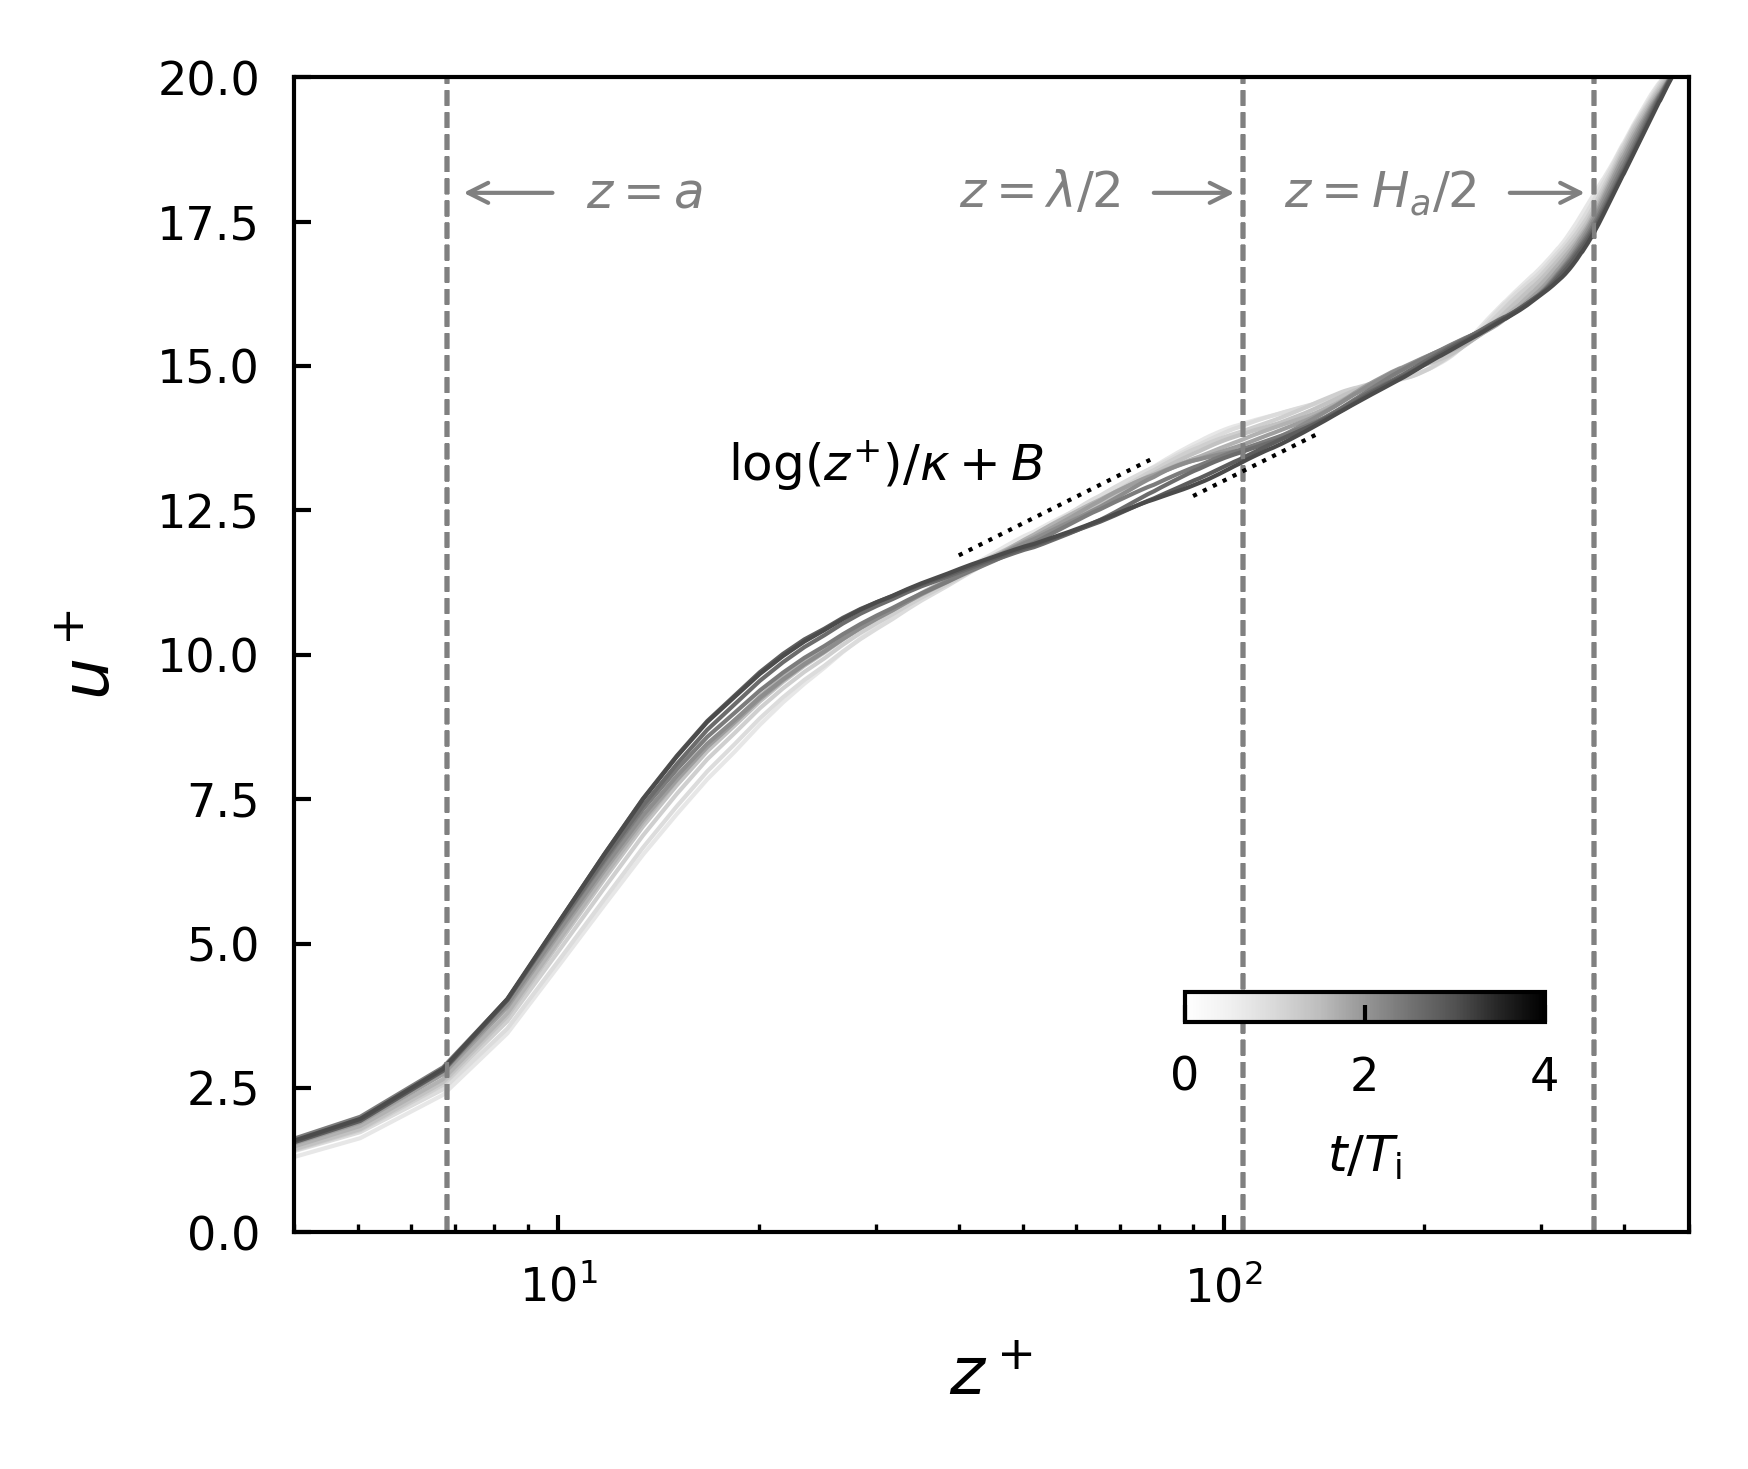

In [112]:
fig = plt.figure(figsize=[3,2.5]); ax = plt.gca()

Tinner = 0.1*(2*np.pi-1)/0.25 # A time scale for the inner layer
N = 4
print(N*Tinner)

ds_pre = ds.where(ds.t < 45, drop=True)
for i in range(0, ds_pre.sizes['t'], 5):
    tsel = ds_pre.t.isel(t=i).values
    print(tsel)
    plot_log(ds_pre.y-1, ds_pre.ux.mean(['x']).isel(t=i), ax=ax, 
             kwargs={'color':plt.get_cmap('Grays')((tsel-40)/(N*Tinner)),'lw':0.5})

for tsel in (45, 45.5, 46, 46.5):
    print(tsel)
    plot_log(ds_pre2.y-1, ds_pre2.ux.mean(['x']).sel(t=tsel, method='nearest'), ax=ax, 
             kwargs={'color':plt.get_cmap('Grays')((tsel-40)/(N*Tinner)),'lw':0.5})


x = np.arange(40,80)
y = np.log(x)/0.4 + 2.5
plt.plot(x, y, ':', c='k', label='$\log(z^{+})/0.4$')

x = np.arange(90,140)
y = np.log(x)/0.4 + 1.5
plt.plot(x, y, ':', c='k', label='$\log(z^{+})/0.4$')

plt.text(18, 13, '$\log(z^{+})/\kappa + B$', fontsize=6)


plt.annotate('$z=a$', xy=(6.8, 18), xytext=(11, 18), arrowprops=dict(arrowstyle='->', lw=0.5, color='gray'), ha = 'left', va='center', fontsize=6, c='gray')
plt.annotate('$z=\lambda/2$', xy=(110, 18), xytext=(70, 18), arrowprops=dict(arrowstyle='->', lw=0.5, color='gray'), ha = 'right', va='center', fontsize=6, c='gray')
plt.annotate('$z=H_a/2$', xy=(370, 18), xytext=(240, 18), arrowprops=dict(arrowstyle='->', lw=0.5, color='gray'), ha = 'right', va='center', fontsize=6, c='gray')


vmin = 0; vmax = 4
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)  # Set vmin/vmax to match the range of `i`
sm = plt.cm.ScalarMappable(cmap='Grays', norm=norm) # Create a ScalarMappable for the colorbar
sm.set_array([])  # Required to set an array for ScalarMappable
cbar_ax = fig.add_axes([0.62,0.25,0.2,0.02])  
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'$t/T_{\mathrm{i}}$', fontsize=6)
cbar.set_ticks([0,2,4])

fig.savefig('../../plots/transition.pdf', bbox_inches='tight')

### Mean profile and roughness length

In [6]:
ds = xr.load_dataset(DATAPATH + 'NWP_ZPG_CU4/span_aver.nc')
ux = ds.ux.mean(dim=['x'])

t=45
Fit only z0: 0.00239
Fit z0: 0.00134, ustar: 0.22526
t=47
Fit only z0: 0.00246
Fit z0: 0.00078, ustar: 0.20499
t=49
Fit only z0: 0.00242
Fit z0: 0.00027, ustar: 0.17651
t=51
Fit only z0: 0.00249
Fit z0: 0.00129, ustar: 0.22198
t=45
Fit only z0: 0.00260
Fit z0: 0.00311, ustar: 0.25883
t=47
Fit only z0: 0.00302
Fit z0: 0.00322, ustar: 0.25316
t=49
Fit only z0: 0.00304
Fit z0: 0.00498, ustar: 0.27709
t=51
Fit only z0: 0.00287
Fit z0: 0.00683, ustar: 0.30134
t=53
Fit only z0: 0.00284
Fit z0: 0.00165, ustar: 0.22607
t=55
Fit only z0: 0.00270
Fit z0: 0.00535, ustar: 0.28825
t=57
Fit only z0: 0.00288
Fit z0: 0.00187, ustar: 0.23042
t=59
Fit only z0: 0.00297
Fit z0: 0.00605, ustar: 0.29105
t=45
Fit only z0: 0.00333
Fit z0: 0.00061, ustar: 0.18589
t=47
Fit only z0: 0.00357
Fit z0: 0.00434, ustar: 0.26041
t=49
Fit only z0: 0.00366
Fit z0: 0.00634, ustar: 0.28200
t=51
Fit only z0: 0.00390
Fit z0: 0.01000, ustar: 0.31121
t=53
Fit only z0: 0.00364
Fit z0: 0.00759, ustar: 0.29465
t=55
Fit only 

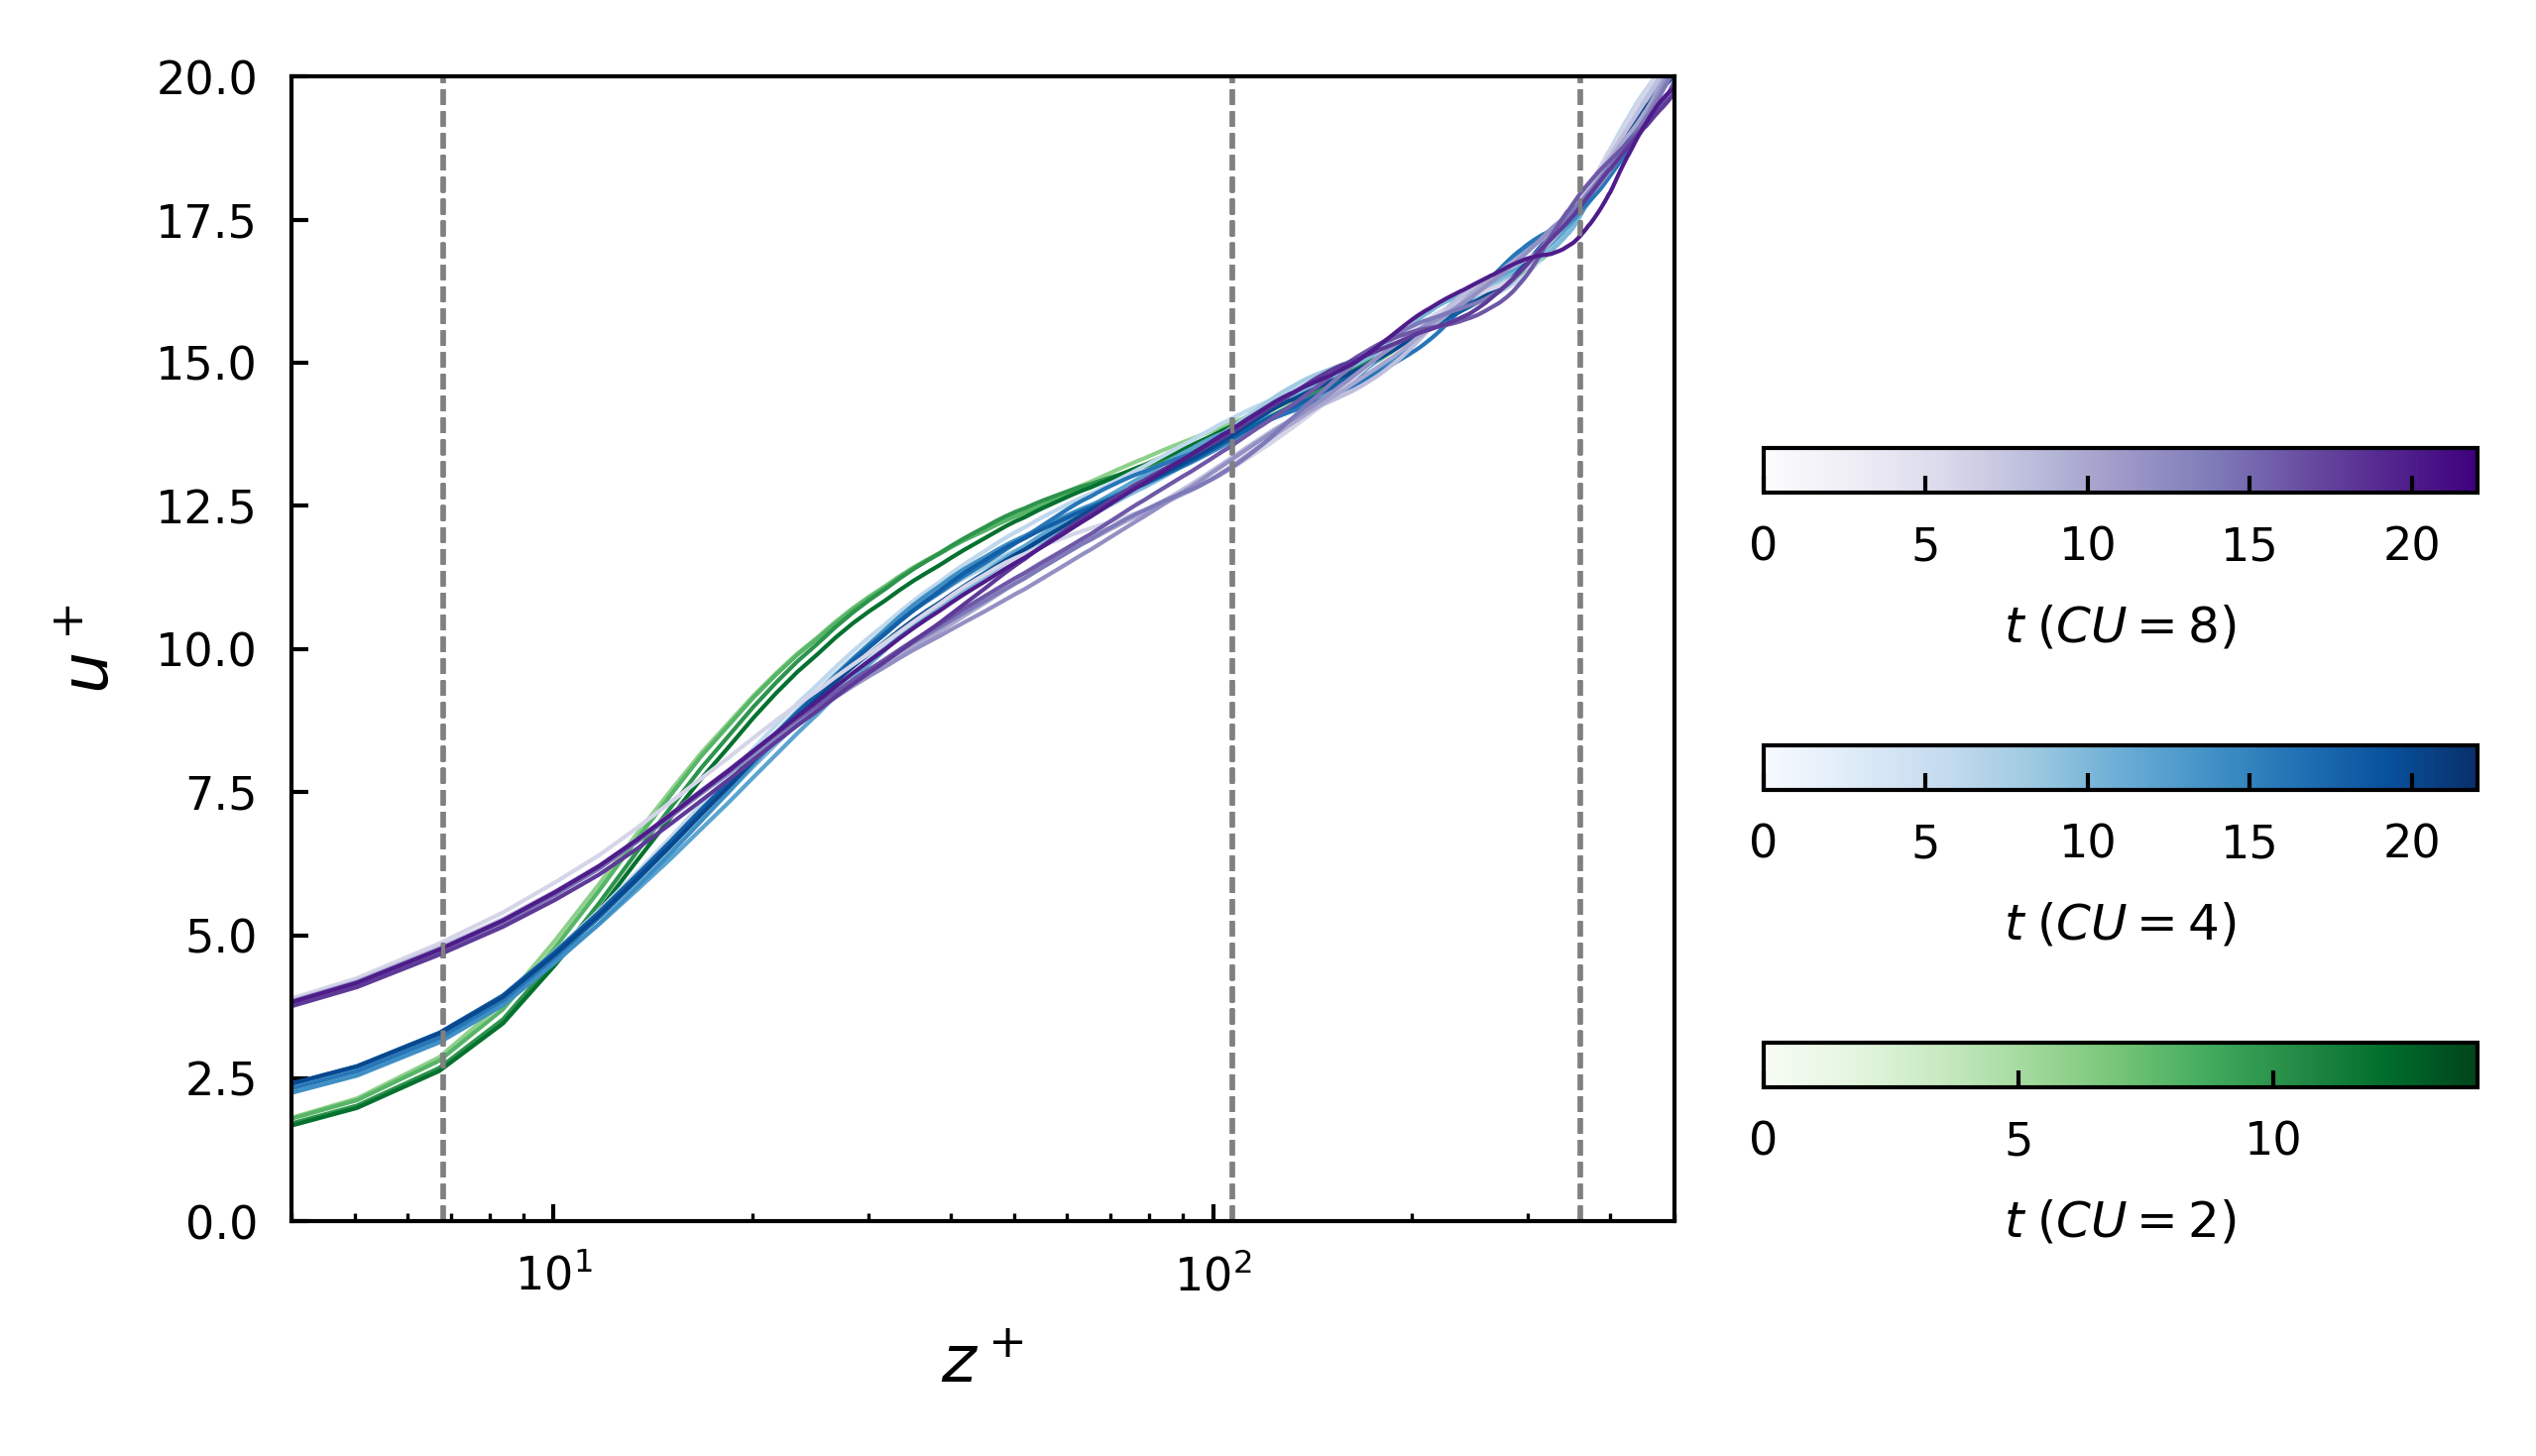

In [7]:
''' Plotting functions that retains the time info '''

def plot(ds, cmap_name, ax):
    ux = ds.ux.mean(dim=['x'])
    ux_chunked_mean = ux.coarsen(t=10, boundary="trim").mean()
    
    N = ux_chunked_mean.sizes['t'] + 2 # a rough range of colorbar
    for t in range(5, ux_chunked_mean.sizes['t'], 2):
        tsel = t + ds.attrs['start_time']
        plot_log(ux_chunked_mean.y-1, ux_chunked_mean.sel(t=tsel, method='nearest'), ax=ax, 
                 kwargs={'color':plt.get_cmap(cmap_name)((t+1)/N),'lw':0.5})
        print('t=%g' %tsel)
        fit(ux_chunked_mean.sel(t=tsel, method='nearest'))

    return N

fig, ax = plt.subplots(figsize=[3,2.5])
cmaps = ['Greens', 'Blues', 'Purples']
cbar_locs = [[0.95, 0.2, 0.4, 0.03], [0.95, 0.4, 0.4, 0.03], [0.95, 0.6, 0.4, 0.03]]
cbar_labels = ['$t \; (CU=2)$', '$t \; (CU=4)$', '$t \; (CU=8)$']
# files = ['NWP_ZPG_CU2/span_aver.nc', 'NWP_ZPG_CU4/span_aver.nc', 'NWP_ZPG_CU8/span_aver.nc']
files = ['CU2/span_aver.nc', 'CU4/span_aver.nc', 'CU8/span_aver.nc']

Nmaxs = []
for i in range(0,3):
    ds = xr.load_dataset(DATAPATH + files[i])
    ds.attrs['start_time'] = 40
    Nmax = plot(ds, cmaps[i], ax=ax)
    Nmaxs.append(Nmax)

for i in range(0,3):
    vmin = 0; vmax = Nmaxs[i]
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)  # Set vmin/vmax to match the range of `i`
    sm = plt.cm.ScalarMappable(cmap=cmaps[i], norm=norm) # Create a ScalarMappable for the colorbar
    sm.set_array([])  # Required to set an array for ScalarMappable
    cbar_ax = fig.add_axes(cbar_locs[i])  
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(cbar_labels[i], fontsize=6)

In [15]:
def fit(ux):
    window1 = 90; window2 = 130
    zwall = (2*np.pi-1)/720.
    region = ((ux.y-1) > zwall*window1) & ((ux.y-1) < zwall*window2)
    ux_fit = ux.where(region, drop=True)
    popt1, pcov = curve_fit(loglaw1, ux_fit.y.values-1, ux_fit.values, bounds=([0], [np.inf]))
    print('Fit only z0: %.5f' %popt1[0])
    popt2, pcov = curve_fit(loglaw2, ux_fit.y.values-1, ux_fit.values, bounds=([0, 0], [np.inf, np.inf]))
    print('Fit z0: %.5f, ustar: %.5f' %(popt2[0],popt2[1]))
    return (popt1, popt2)

6.450000000000159
Fit only z0: 0.00265
Fit z0: 0.00212, ustar: 0.24064
12.950000000000273
Fit only z0: 0.00282
Fit z0: 0.00309, ustar: 0.25411
14.450000000000273
Fit only z0: 0.00305
Fit z0: 0.01202, ustar: 0.33161


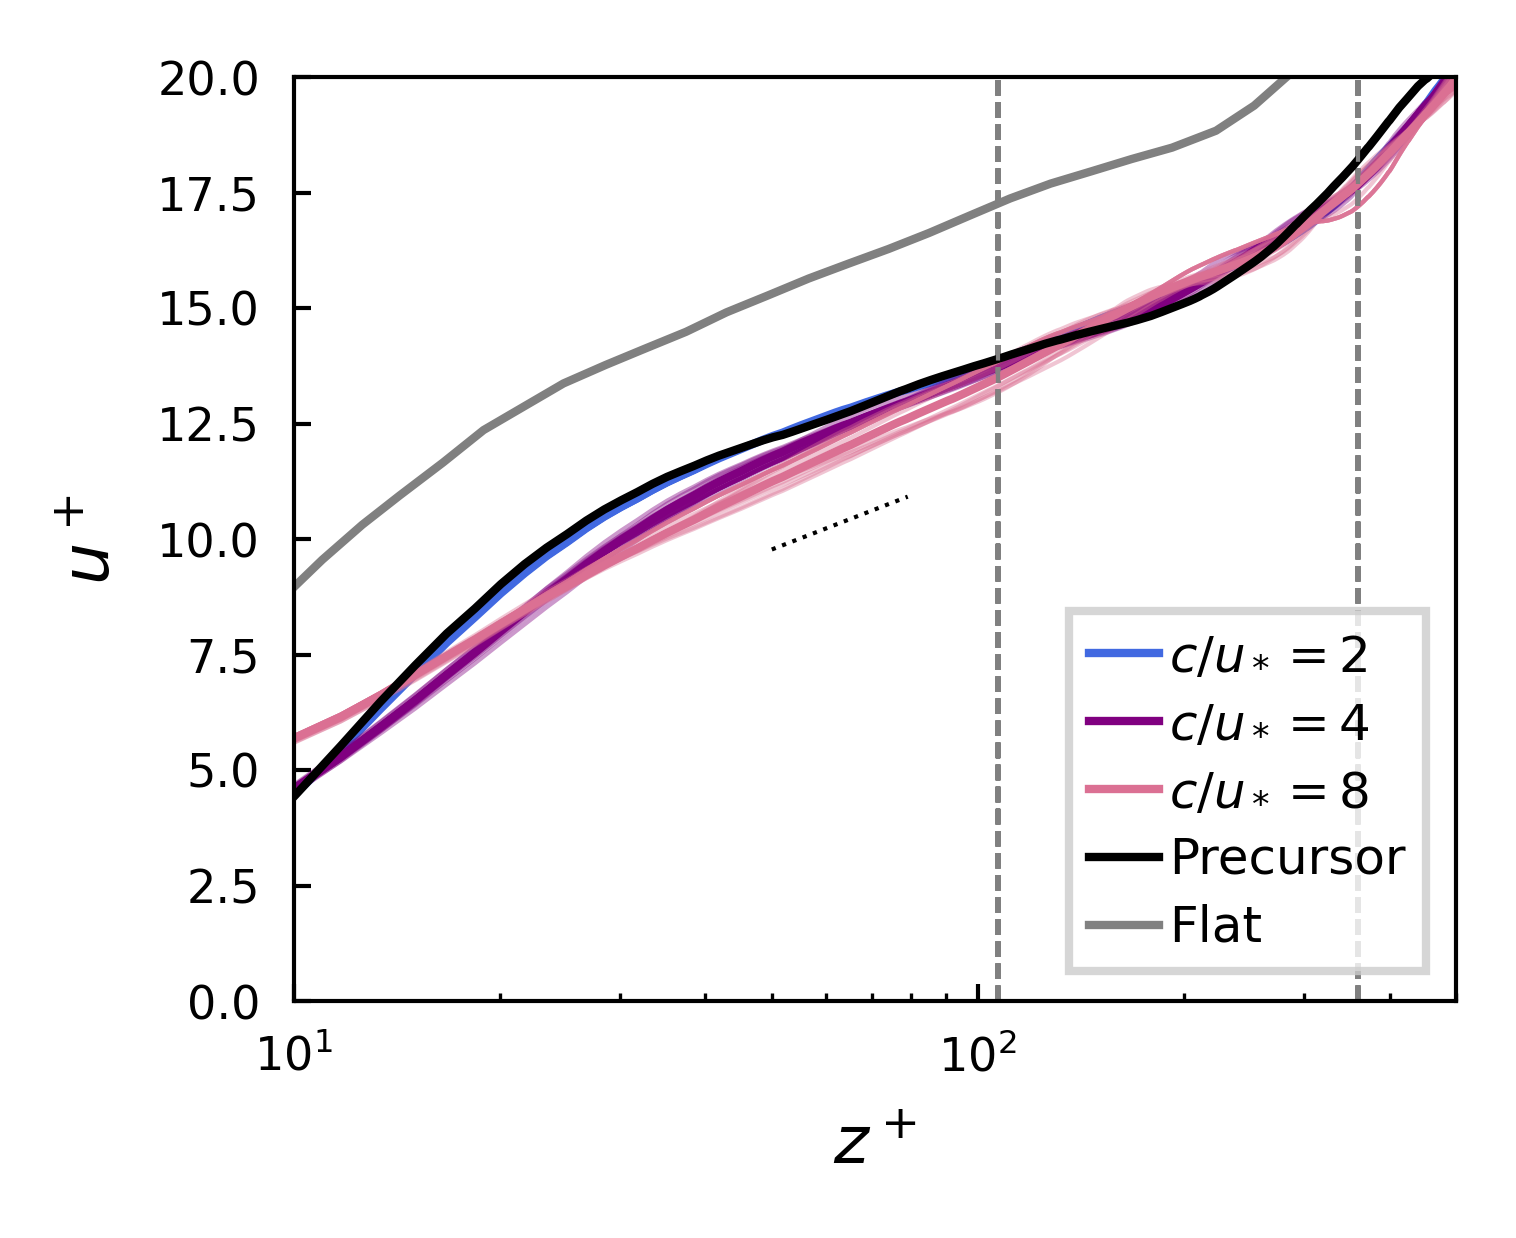

In [45]:
''' Plotting functions that removes the time info '''

# Read in flatwall 
import pandas as pd
df = pd.read_csv('../../data/flat_wall.txt', names=['z','u'])


def plot(ds, color, ax, kwargs):
    ux = ds.ux.mean(dim=['x'])
    ux_ = ux.coarsen(t=10, boundary="trim").mean()
    print(ux_.t.isel(t=-1).values-ds.attrs['start_time'])
    # window_mean = ux_.where((ux_.t>6+ds.attrs['start_time'])&(ux_.t<11+ds.attrs['start_time']), drop=True).mean('t')
    window_mean = ux_.where(ux_.t>5+ds.attrs['start_time'], drop=True).mean('t')
    for t in range(5, ux_.sizes['t']):
        plot_log(ux_.y-1, ux_.sel(t=t+ds.attrs['start_time'],method='nearest'), 
                 ax=ax, kwargs={'color':color,'lw':0.5, 'alpha':0.4})
    plot_log(ux_.y-1, window_mean, ax=ax, kwargs={'color':color,'lw':1, **kwargs})
    
    return window_mean

fig, ax = plt.subplots(figsize=[2.5,2])
colors = ['royalblue', 'purple', 'palevioletred']
cbar_labels = ['$t \; (CU=2)$', '$t \; (CU=4)$', '$t \; (CU=8)$']
files = ['NWP_ZPG_CU2/span_aver.nc', 'NWP_ZPG_CU4/span_aver.nc', 'NWP_ZPG_CU8/span_aver.nc']
# files = ['CU2/span_aver.nc', 'CU4/span_aver.nc', 'CU8/span_aver.nc']
labels = [r'$c/u_*=2$', r'$c/u_*=4$', r'$c/u_*=8$']

popt1_list = []
popt2_list = []
for i in range(0,3):
    ds = xr.load_dataset(DATAPATH + files[i])
    ds.attrs['start_time'] = 45
    window_mean = plot(ds, colors[i], ax=ax, kwargs={'label':labels[i]})
    popt1, popt2 = fit(window_mean)
    popt1_list.append(popt1)
    popt2_list.append(popt2)


# Draw two lines
# x = np.arange(90,130)
# y = np.log(x)/0.4 
# plt.plot(x, y, ':', c='k')
x = np.arange(50,80)
y = np.log(x)/0.4
plt.plot(x, y, ':', c='k')

# Precursor
ds_pre = xr.load_dataset(DATAPATH + 'CU4/span_aver.nc')
plot_log(ds_pre.y-1, ds_pre.sel(t=40,method='nearest').ux.mean(dim=['x']), 
         ax=ax, kwargs={'color':'k', 'lw':1, 'label':'Precursor'})
# ds_pre = xr.load_dataset(DATAPATH + 'NWP_ZPG_CU4/span_aver.nc')
# plot_log(ds_pre.y-1, ds_pre.sel(t=45,method='nearest').ux.mean(dim=['x']), 
#          ax=ax, kwargs={'color':'k', 'lw':1, 'label':'Precursor'})

# Flat wall
plt.plot(df.z, df.u, c='gray', lw=1, label='Flat')

ax.set_xlim([10,500])
ax.legend(loc='lower right', fontsize=6)

# fig.savefig('../../plots/NWP_ZPG_roughness.pdf',bbox_inches='tight')
fig.savefig('../../plots/roughness.pdf',bbox_inches='tight')

In [69]:
np.log(100*(2*np.pi-1)/720/0.00243)/0.41

13.927590705614191

In [71]:
np.log(100)/0.41 + 6

17.232122404849

In [ ]:
### t = 5 to end

Fit only z0: 0.00243
Fit z0: 0.00075, ustar: 0.20422
Fit only z0: 0.00290
Fit z0: 0.00420, ustar: 0.26974
Fit only z0: 0.00347
Fit z0: 0.00688, ustar: 0.29057

# 5 to 10
Fit only z0: 0.00242
Fit z0: 0.00053, ustar: 0.19411
Fit only z0: 0.00299
Fit z0: 0.00453, ustar: 0.27234
Fit only z0: 0.00352
Fit z0: 0.00376, ustar: 0.25342
# 6 to 11
Fit only z0: 0.00243
Fit z0: 0.00058, ustar: 0.19646
Fit only z0: 0.00299
Fit z0: 0.00483, ustar: 0.27636
Fit only z0: 0.00360
Fit z0: 0.00547, ustar: 0.27348
# 7 to 12
Fit only z0: 0.00245
Fit z0: 0.00067, ustar: 0.20049
Fit only z0: 0.00294
Fit z0: 0.00546, ustar: 0.28471
Fit only z0: 0.00372
Fit z0: 0.00709, ustar: 0.28853
# 8 to 13
Fit only z0: 0.00245
Fit z0: 0.00065, ustar: 0.19936
Fit only z0: 0.00291
Fit z0: 0.00482, ustar: 0.27753
Fit only z0: 0.00377
Fit z0: 0.00826, ustar: 0.29865


In [ ]:
Original - window [50,80]
CU2: [0.00243, 0.00245]
CU4: [0.00290, 0.00299]
CU8: [0.00347, 0.00377]

In [65]:
l_nu = (2*np.pi-1)/720
np.array([[0.00243, 0.00245],[0.00290, 0.00299],[0.00347, 0.00377]])/l_nu

array([[0.33116385, 0.33388948],
       [0.39521612, 0.40748145],
       [0.47289653, 0.51378096]])

In [ ]:
### NWP

# window [50,80]
# 4 to 9
Fit only z0: 0.00287
Fit z0: 0.00056, ustar: 0.18945
Fit only z0: 0.00338
Fit z0: 0.00155, ustar: 0.21578
Fit only z0: 0.00355
Fit z0: 0.00329, ustar: 0.24616
# 5 to 10
Fit only z0: 0.00289
Fit z0: 0.00071, ustar: 0.19584
Fit only z0: 0.00348
Fit z0: 0.00134, ustar: 0.20910
Fit only z0: 0.00360
Fit z0: 0.00329, ustar: 0.24554
# 6 to 11
Fit only z0: 0.00295
Fit z0: 0.00068, ustar: 0.19393
Fit only z0: 0.00358
Fit z0: 0.00143, ustar: 0.21042
Fit only z0: 0.00366
Fit z0: 0.00366, ustar: 0.24987

CU2: [0.00287, 0.00295]
CU4: [0.00338, 0.00358]
CU8: [0.00355, 0,00373]

# window [90,130]
Fit only z0: 0.00340
Fit z0: 0.00050, ustar: 0.18504
Fit only z0: 0.00380
Fit z0: 0.00146, ustar: 0.21212
Fit only z0: 0.00397
Fit z0: 0.00081, ustar: 0.19229

Fit only z0: 0.00343
Fit z0: 0.00028, ustar: 0.17132
Fit only z0: 0.00390
Fit z0: 0.00178, ustar: 0.21793
Fit only z0: 0.00400
Fit z0: 0.00058, ustar: 0.18326

Fit only z0: 0.00345
Fit z0: 0.00039, ustar: 0.17835
Fit only z0: 0.00397
Fit z0: 0.00200, ustar: 0.22143
Fit only z0: 0.00400
Fit z0: 0.00103, ustar: 0.19891

CU2: [0.00340, 0.00345]
CU4: [0.00380, 0.00397]
CU8: [0.00397, 0.00400]

In [13]:
l_nu = (2*np.pi-1)/720

print(np.array([[0.00287, 0.00295],[0.00338, 0.00358],[0.00355, 0.00373]])/l_nu)
print(np.array([[0.00340, 0.00345],[0.00380, 0.00397],[0.00397, 0.00400]])/l_nu)

[[0.39112768 0.40203019]
 [0.4606312  0.48788749]
 [0.48379904 0.5083297 ]]
[[0.46335683 0.4701709 ]
 [0.5178694  0.54103724]
 [0.54103724 0.54512568]]


In [ ]:
# Select the data within the time range
fig = plt.figure(figsize=[2,1.5])


plt.plot((ds_stat.y-1)/zwall, ds_stat.ux.mean(dim=['x','t'])/ustar, ':', color='k', label='stationary')

for i in range(10, ds.sizes['t'], 10):
    plt.plot((ds.y-1)/zwall, ds.ux.isel(t=i).mean(dim=['x'])/ustar, 
             c=plt.get_cmap('Blues')(i/ds.sizes['t']))

plt.axvline(x=0.2/4/zwall, linestyle='--', c='gray')
# plt.axvline(x=2*np.pi/4/zwall, linestyle='--', c='gray')
plt.axvline(x=2*np.pi/4/zwall/2, linestyle='--', c='gray')
plt.axvline(x=(2*np.pi-1)/2./zwall, linestyle='--', c='gray')

plt.xlim([4,500]); plt.ylim([0,20])
plt.xscale('log')
plt.xlabel('$z^+$'); plt.ylabel('$u^+$')
plt.title('Mean velocity (fixed coordinate)', fontsize=6)
plt.legend(fontsize=6)

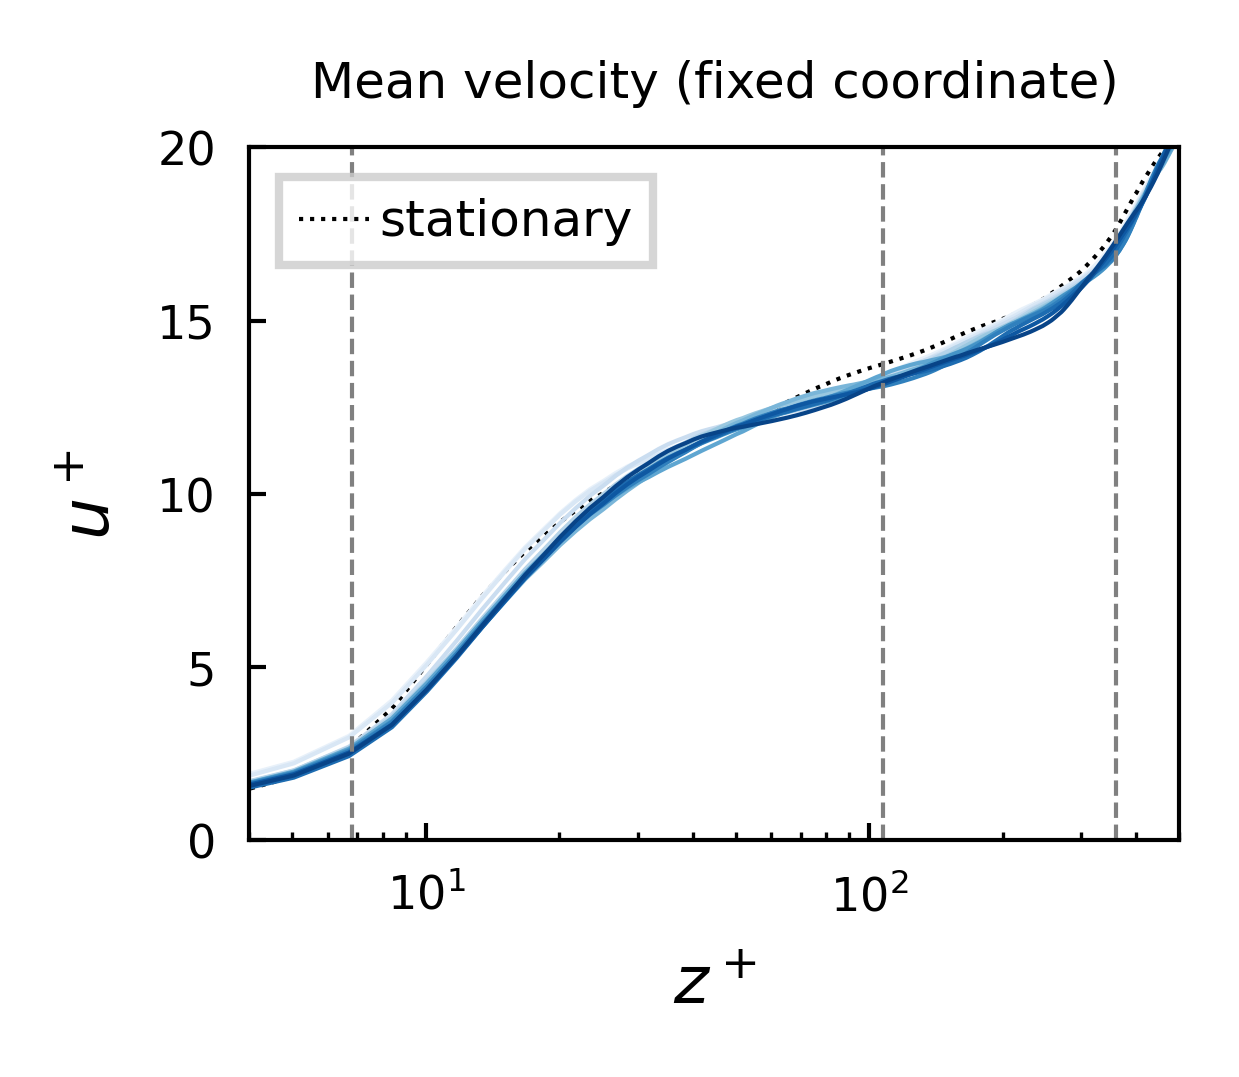

In [14]:
# Select the data within the time range
fig = plt.figure(figsize=[2,1.5])
zwall = (2*np.pi-1)/720.
ustar = 0.25

plt.plot((ds_stat.y-1)/zwall, ds_stat.ux.mean(dim=['x','t'])/ustar, ':', color='k', label='stationary')

ds = ds_CU2
for i in range(10, ds.sizes['t'], 10):
    plt.plot((ds.y-1)/zwall, ds.ux.isel(t=i).mean(dim=['x'])/ustar, 
             c=plt.get_cmap('Blues')(i/ds.sizes['t']))


plt.axvline(x=0.2/4/zwall, linestyle='--', c='gray')
# plt.axvline(x=2*np.pi/4/zwall, linestyle='--', c='gray')
plt.axvline(x=2*np.pi/4/zwall/2, linestyle='--', c='gray')
plt.axvline(x=(2*np.pi-1)/2./zwall, linestyle='--', c='gray')

plt.xlim([4,500]); plt.ylim([0,20])
plt.xscale('log')
plt.xlabel('$z^+$'); plt.ylabel('$u^+$')
plt.title('Mean velocity (fixed coordinate)', fontsize=6)
plt.legend(fontsize=6)

In [ ]:
fig = plt.figure(figsize=[2,1.5])

times = np.arange(45,46)
for i,time in enumerate(times):
    plt.plot((ds_NWP.y-1)/zwall, ds_NWP.ux.sel(t=time,method='nearest').mean(dim=['x'])/ustar, '-', 
             color=plt.get_cmap('Blues')(0.9), label='NWP')

times = np.arange(46,50)
for i,time in enumerate(times):
    plt.plot((ds_NWP.y-1)/zwall, ds_NWP.ux.sel(t=time,method='nearest').mean(dim=['x'])/ustar, '-', 
             color=plt.get_cmap('Greens')((i+1)/5))

times = np.arange(40,41)
for i,time in enumerate(times):
    plt.plot((ds.y-1)/zwall, ds.ux.sel(t=time,method='nearest').mean(dim=['x'])/ustar, '--', 
             color=plt.get_cmap('Blues')(0.9), label='Original')

times = np.arange(41,45)
for i,time in enumerate(times):
    plt.plot((ds.y-1)/zwall, ds.ux.sel(t=time,method='nearest').mean(dim=['x'])/ustar, '--', 
             color=plt.get_cmap('Greens')((i+1)/5))


x = np.arange(50,200)
y = np.log(x)/0.4
plt.plot(x, y, c='k', label='$\log(z^{+})/0.4$')
plt.axvline(x=0.2/4/zwall, linestyle='--', c='gray')
plt.axvline(x=2*np.pi/4/zwall, linestyle='--', c='gray')
plt.xlim([4,500]); plt.ylim([1,20])
plt.xscale('log')
plt.xlabel('$z^+$'); plt.ylabel('$u^+$')
plt.title('Mean velocity (side-by-side)', fontsize=6)
plt.legend(fontsize=6)



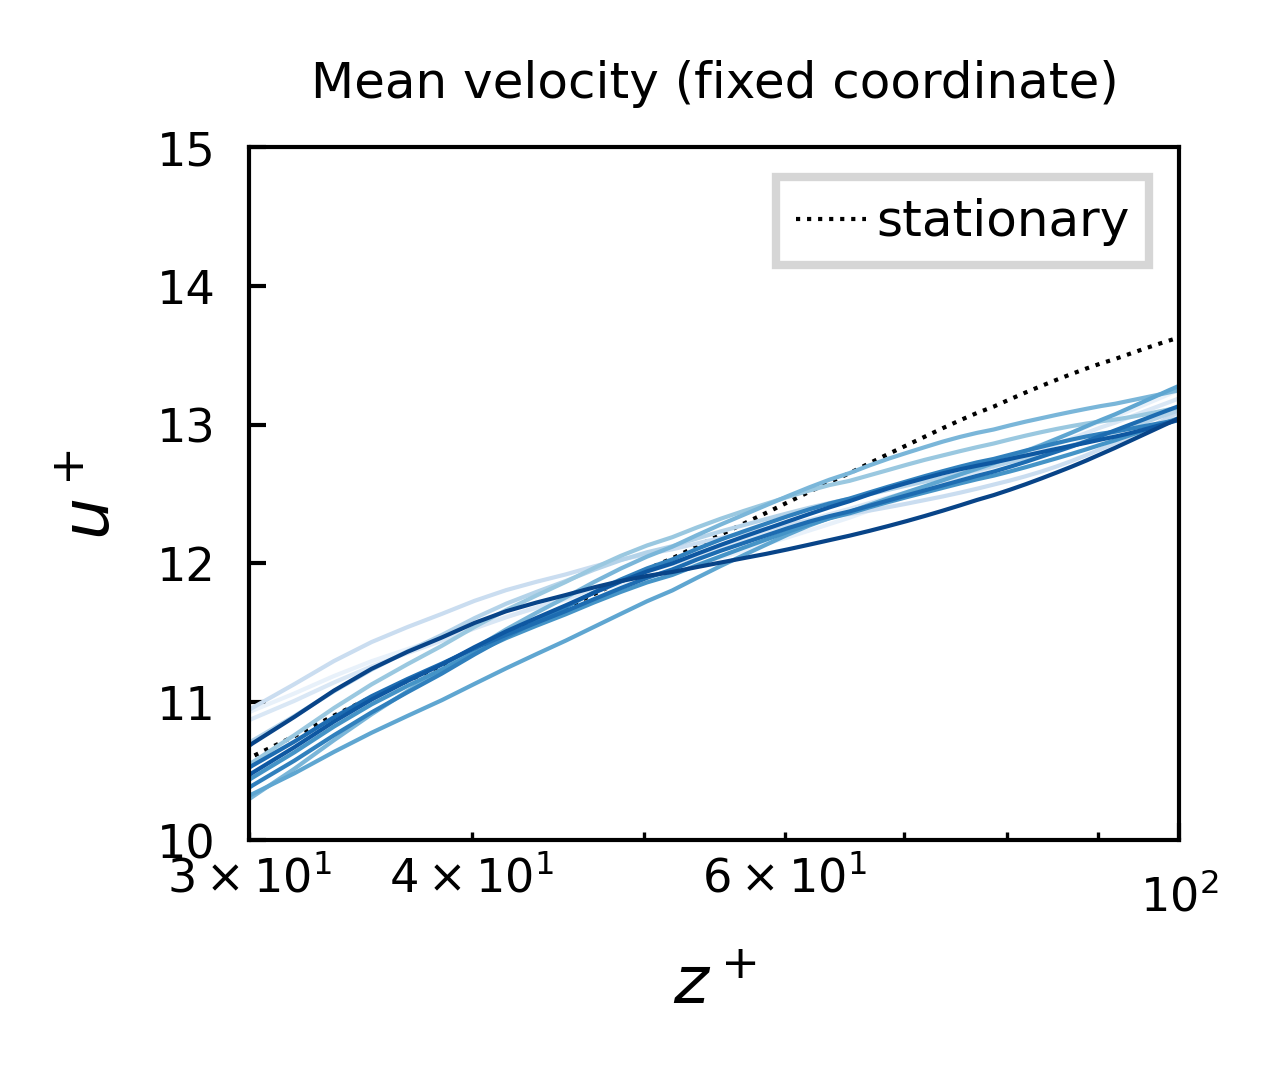

In [13]:
# Select the data within the time range
fig = plt.figure(figsize=[2,1.5])
zwall = (2*np.pi-1)/720.
ustar = 0.25

plt.plot((ds_stat.y-1)/zwall, ds_stat.ux.mean(dim=['x','t'])/ustar, ':', color='k', label='stationary')

ds = ds_CU2
### TODO: resample by taking mean
ds = ds.ux.resample()
for i in range(10, ds.sizes['t'], 10):
    plt.plot((ds.y-1)/zwall, ds.ux.isel(t=i).mean(dim=['x'])/ustar, 
             c=plt.get_cmap('Blues')(i/ds.sizes['t']))


plt.axvline(x=0.2/4/zwall, linestyle='--', c='gray')
# plt.axvline(x=2*np.pi/4/zwall, linestyle='--', c='gray')
plt.axvline(x=2*np.pi/4/zwall/2, linestyle='--', c='gray')
plt.axvline(x=(2*np.pi-1)/2./zwall, linestyle='--', c='gray')

plt.xlim([30,100]); plt.ylim([10,15])
plt.xscale('log')
plt.xlabel('$z^+$'); plt.ylabel('$u^+$')
plt.title('Mean velocity (fixed coordinate)', fontsize=6)
plt.legend(fontsize=6)

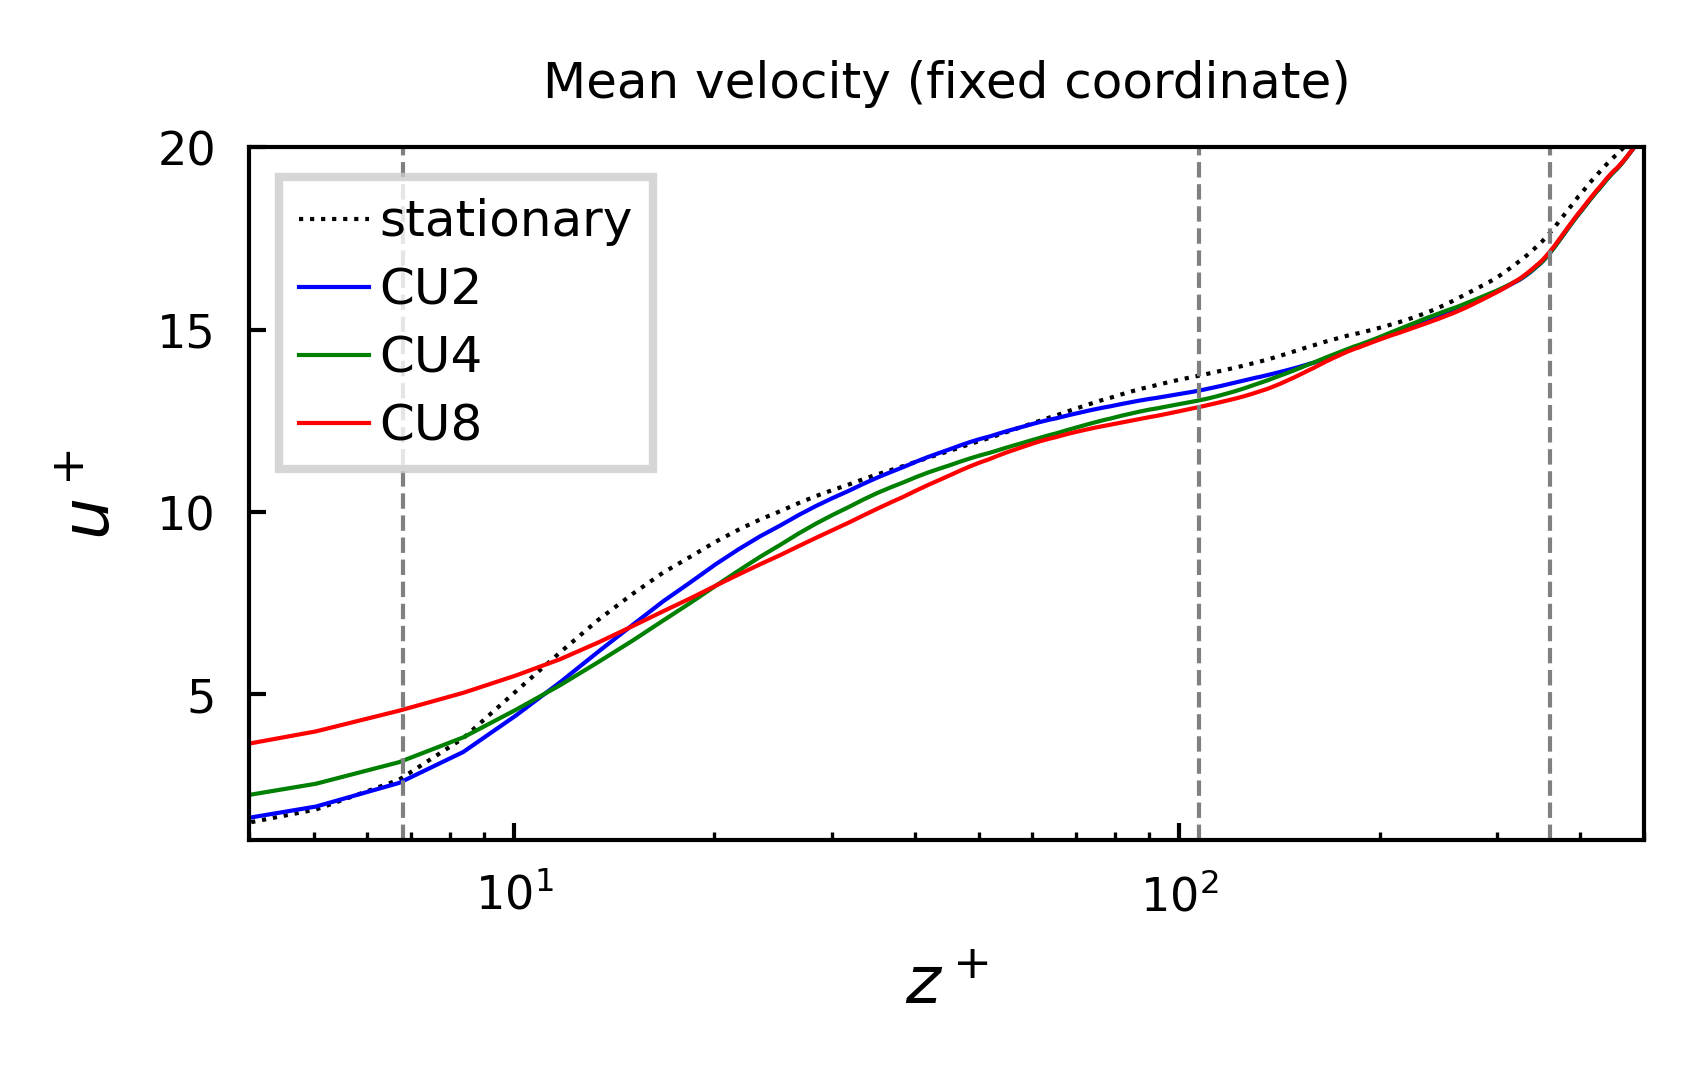

In [45]:
# Select the data within the time range
fig = plt.figure(figsize=[3,1.5])
zwall = (2*np.pi-1)/720.
ustar = 0.25

plt.plot((ds_stat.y-1)/zwall, ds_stat.ux.mean(dim=['x','t'])/ustar, ':', color='k', label='stationary')

labels = ['CU2', 'CU4', 'CU8']
for i, ds in enumerate([ds_CU2,ds_CU4,ds_CU8]):
    plt.plot((ds.y-1)/zwall, ds.ux.isel(t=slice(50,70)).mean(dim=['x','t'])/ustar, label=labels[i])


plt.axvline(x=0.2/4/zwall, linestyle='--', c='gray')
# plt.axvline(x=2*np.pi/4/zwall, linestyle='--', c='gray')
plt.axvline(x=2*np.pi/4/zwall/2, linestyle='--', c='gray')
plt.axvline(x=(2*np.pi-1)/2./zwall, linestyle='--', c='gray')

plt.xlim([4,500]); plt.ylim([1,20])
plt.xscale('log')
plt.xlabel('$z^+$'); plt.ylabel('$u^+$')
plt.title('Mean velocity (fixed coordinate)', fontsize=6)
plt.legend(fontsize=6)

### Phase lag

[Text(-3.141592653589793, 0, '$-\\pi$'),
 Text(-1.5707963267948966, 0, '$-\\pi/2$'),
 Text(0.0, 0, '$0$'),
 Text(1.5707963267948966, 0, '$\\pi/2$'),
 Text(3.141592653589793, 0, '$\\pi$')]

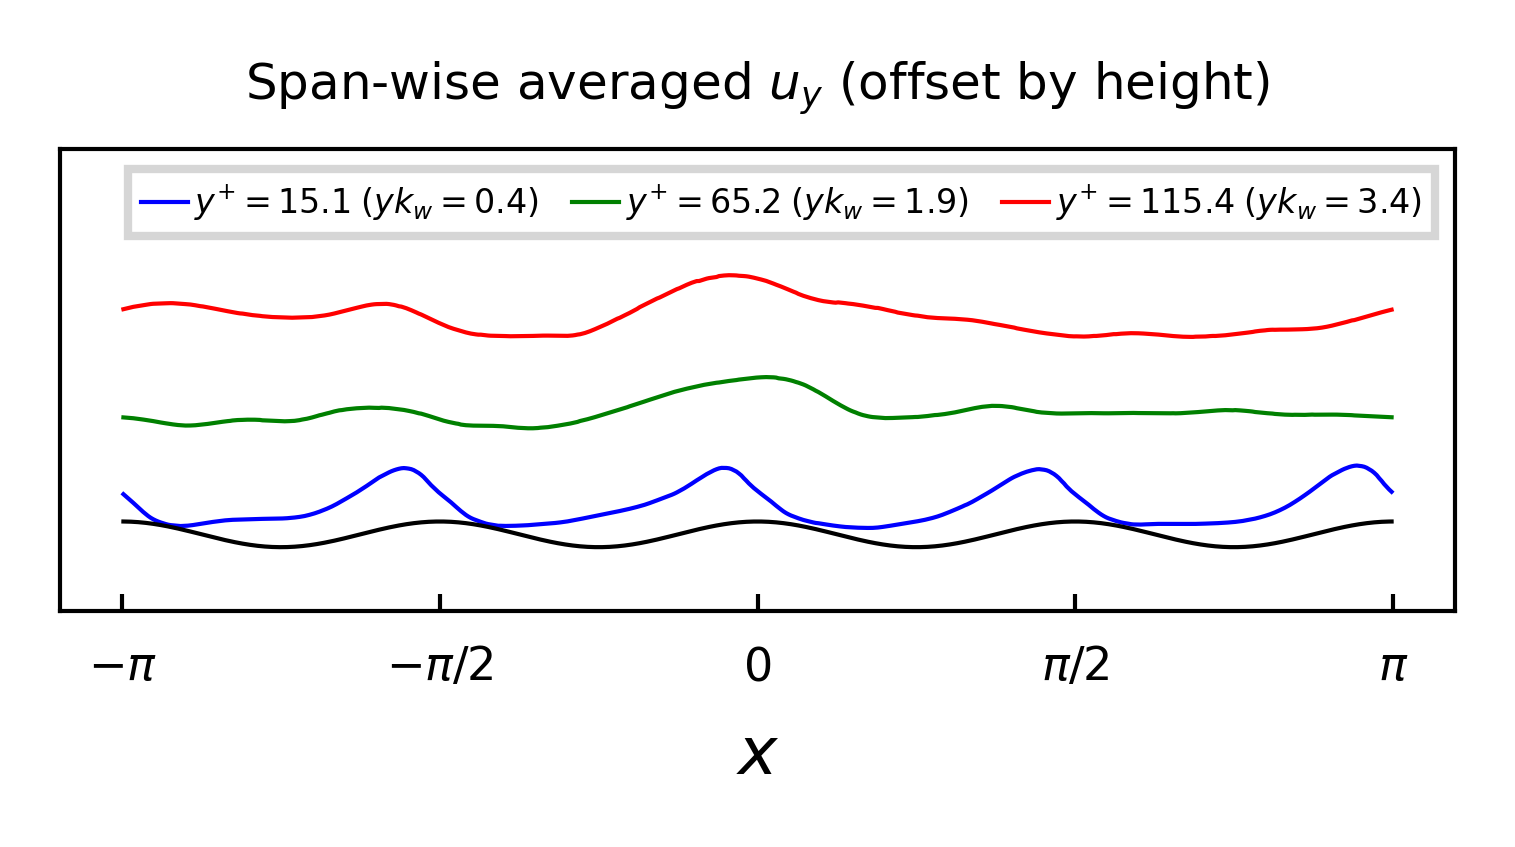

In [11]:
fig = plt.figure(figsize=[3,1])

zwall = (2*np.pi-1)/720
kwave = 4

c = ['b','g','r']
for i, ysel in enumerate((90,120,150)):
    yloc = ds.y.isel(y=ysel) - 1 
    plt.plot(ds.x, ds.uy.isel(t=0,y=ysel)+yloc, c=c[i],
             label='$y^{+}=%.1f \; (yk_w=%.1f)$' %(yloc/zwall,yloc*kwave))
        
plt.ylim([-.3,1.5])
plt.title('Span-wise averaged $u_y$ (offset by height)', fontsize=6)
plt.xlabel('$x$');plt.ylabel('$u_y$')
plt.legend(ncol=3, fontsize=4)
eta = np.cos(ds.x*kwave)*(0.2/kwave)
plt.plot(ds.x,eta,c='k')

ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

In [ ]:
# Specify the path of the folder you want to create
# folder = '../plots/test_full'
# os.makedirs(folder, exist_ok=True)

# for i in range(0,len(ds.t)):   
#     fig = plt.figure(figsize=[3,2])
#     ax = plt.gca()
#     im = ds.uy.isel(t=i).plot(x='x',vmax=0.3,vmin=-0.3,cmap='RdBu_r',
#                          cbar_kwargs={'label':'$u_y$'})
#     ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
#     ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
#     plt.xlabel('$x$'); plt.ylabel('$y$')
#     plt.savefig(folder+'/uy_%g.png' %i)

### 2D field

Text(0, 0.5, '$y$')

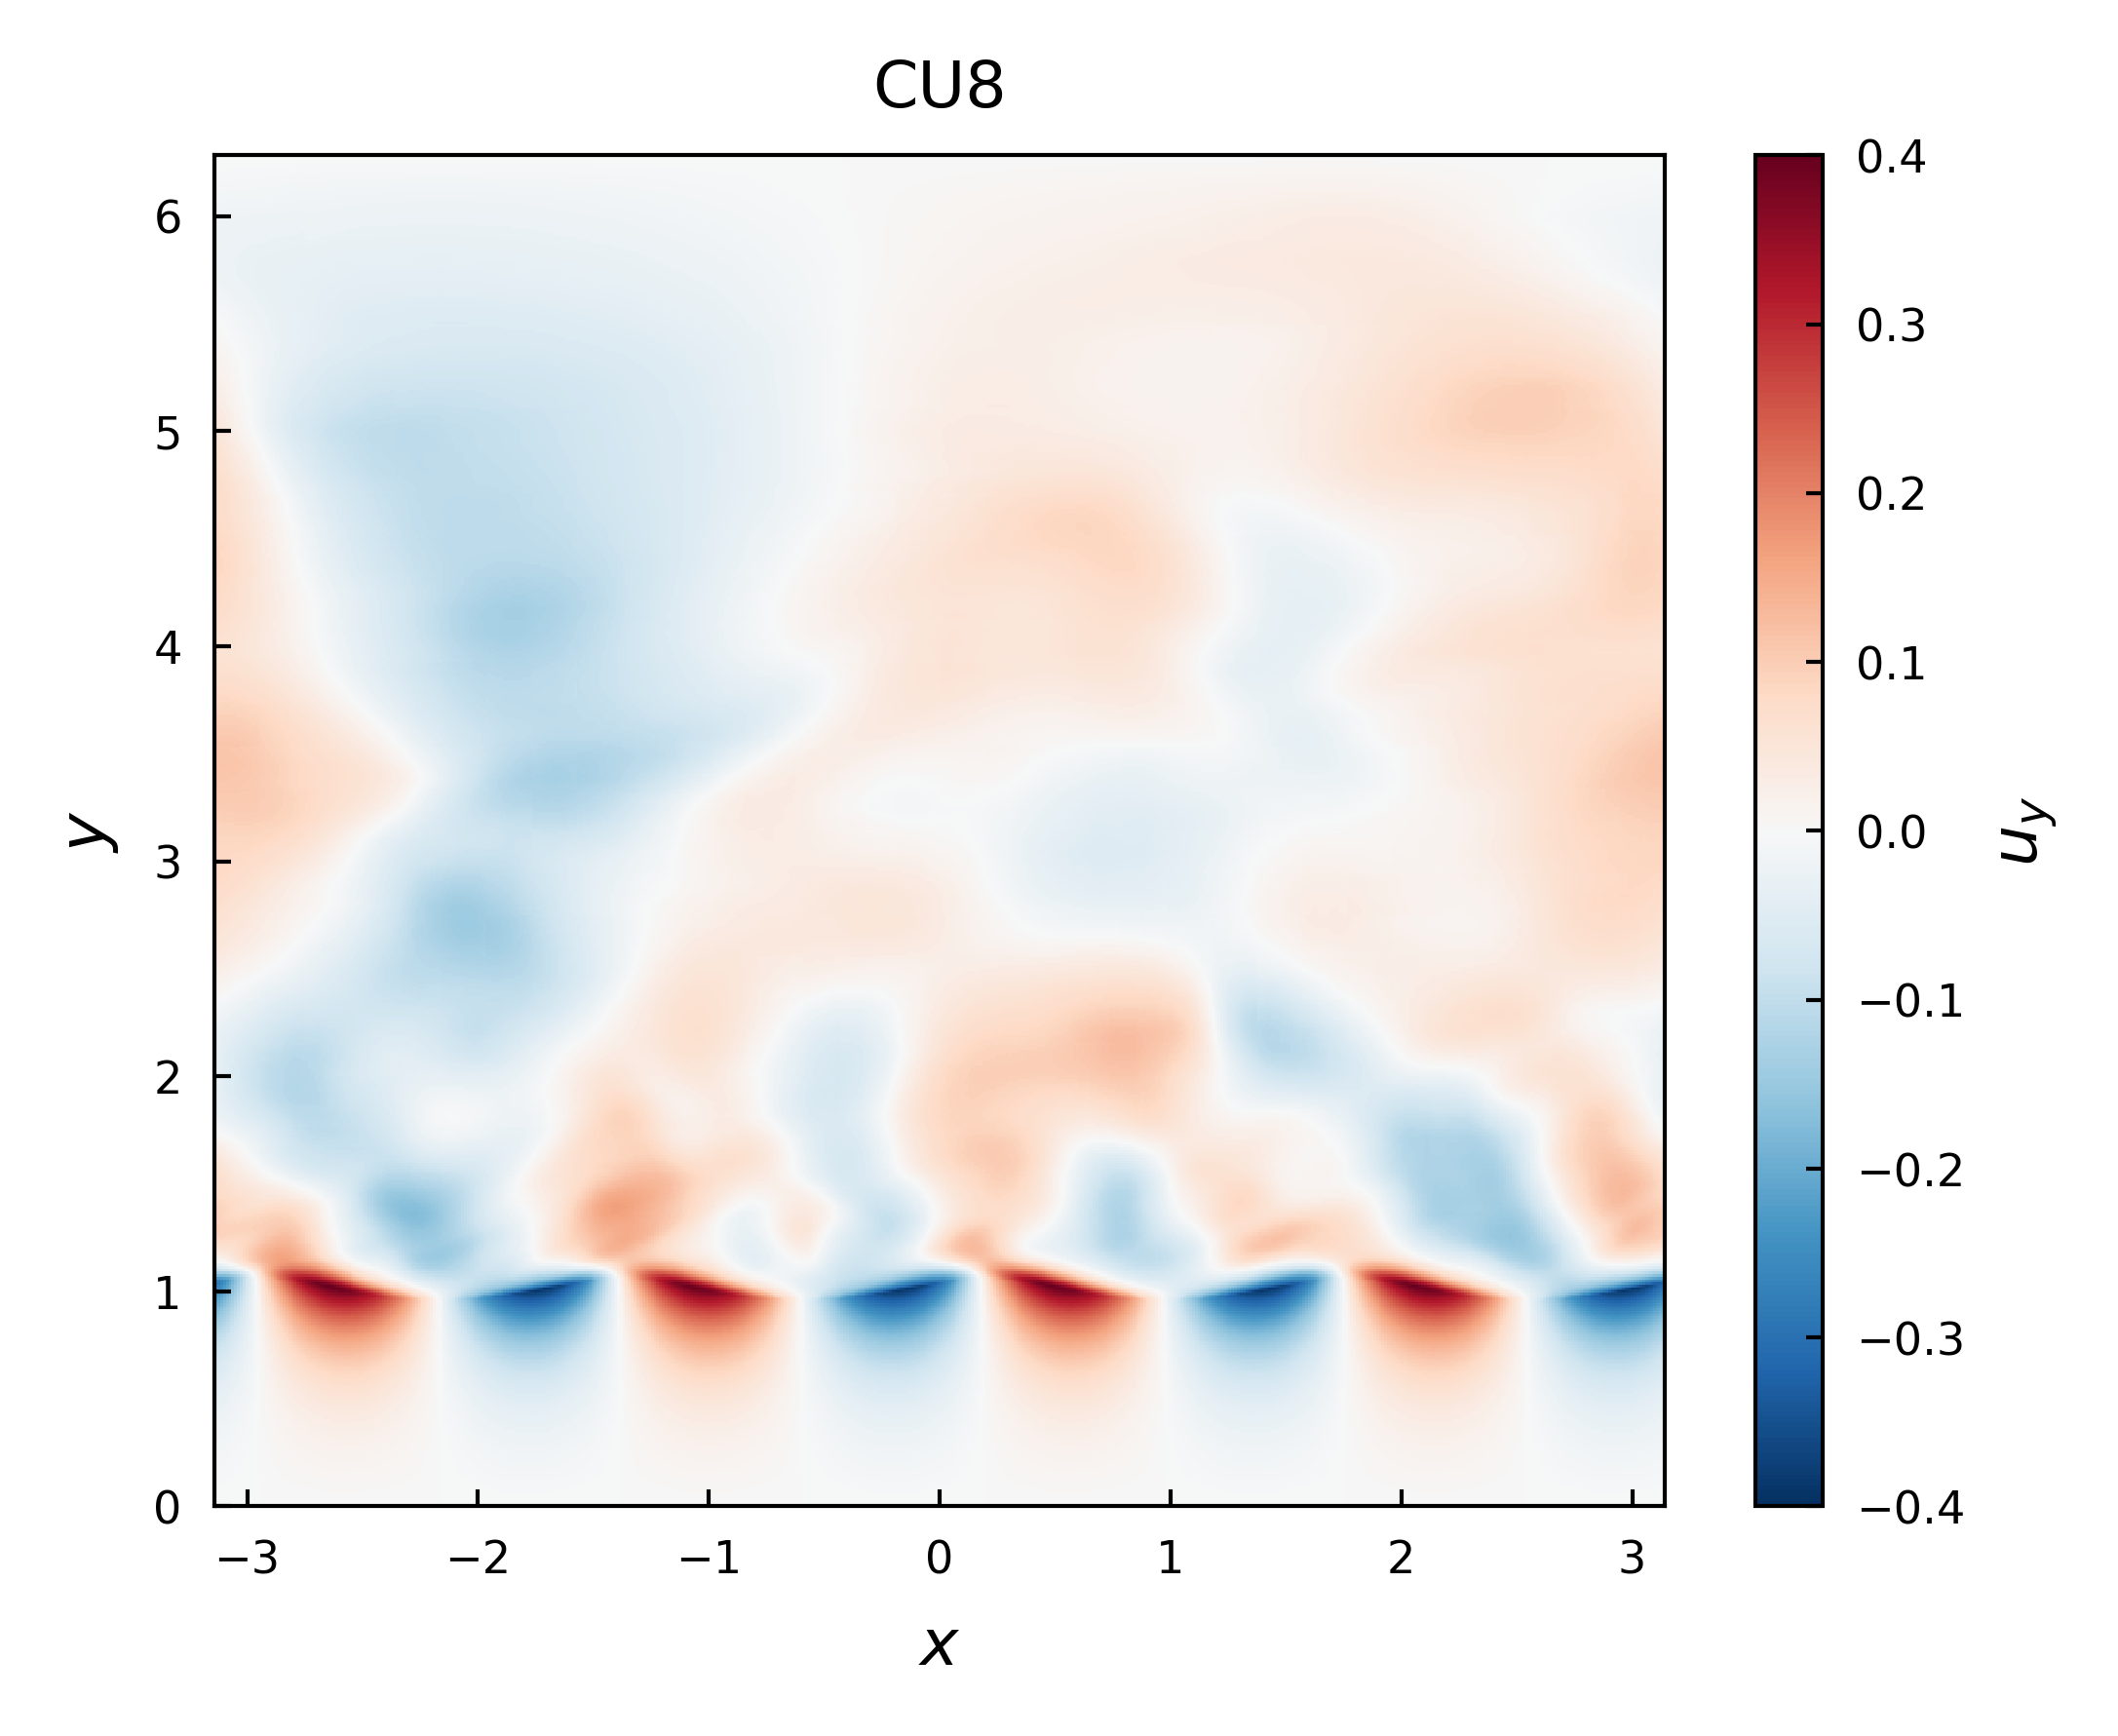

In [29]:
plt.figure(figsize=[4,3])
# pair.isel(t=0).plot(x='x', cmap='RdBu_r')
time = 52
ds_CU8.uy.sel(t=time, method='nearest').plot(x='x', cmap='RdBu_r', vmax=0.4, vmin=-0.4, 
                                            cbar_kwargs={'label':'$u_y$'})
plt.title('CU8'); plt.xlabel('$x$'); plt.ylabel('$y$')

In [ ]:
plt.figure(figsize=[3,3])
# pair.isel(t=0).plot(x='x', cmap='RdBu_r')
time = 39.5
(ds_NWP2.uy.sel(t=time)).plot(x='x', cmap='RdBu_r')

In [41]:
path = '/home/ctrsp-2024/jiarongw/outputs/test_NWP_ZPG/'
times = np.arange(39.5,40,0.5)
ds_NWP2 = read_fields_2D(path, times, NSLICE=512, NGRID=512, varlist=['ux','uy','uz','f','ax','pair'])
ds_NWP2

<xarray.Dataset> Size: 13MB
Dimensions:  (t: 1, x: 512, y: 512)
Coordinates:
  * t        (t) float64 8B 39.5
  * x        (x) float64 4kB -3.135 -3.123 -3.111 -3.099 ... 3.111 3.123 3.135
  * y        (y) float64 4kB 0.006136 0.01841 0.03068 ... 6.253 6.265 6.277
Data variables:
    ux       (t, x, y) float64 2MB 7.409e-07 7.409e-07 7.409e-07 ... 5.449 5.449
    uy       (t, x, y) float64 2MB -8.223e-07 -2.467e-06 ... -5.019e-05
    uz       (t, x, y) float64 2MB 1.127e-13 1.127e-13 ... 0.0002173 0.0002173
    f        (t, x, y) float64 2MB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    ax       (t, x, y) float64 2MB 0.01055 0.01055 0.01055 ... 0.04634 0.04634
    pair     (t, x, y) float64 2MB 0.0 0.0 0.0 0.0 ... 0.06653 0.06653 0.06653

In [42]:
def convert_to_0_2pi(angle_rad_original):
    angle_rad = angle_rad_original % (2 * np.pi)  # Ensure angle is within [0, 2*pi)
    np.where(angle_rad < 0, angle_rad + 2 * np.pi, angle_rad)    
    return angle_rad

kx = 4
xtemp = ds_NWP2.x.copy(deep=True).values
theta = convert_to_0_2pi(xtemp*kx)
ds_NWP2 = ds_NWP2.assign_coords({'x': theta})
ds_NWP2 = ds_NWP2.rename({'x': 'phase'})
ds_NWP2 = ds_NWP2.assign_coords({'x': ('phase', xtemp)})


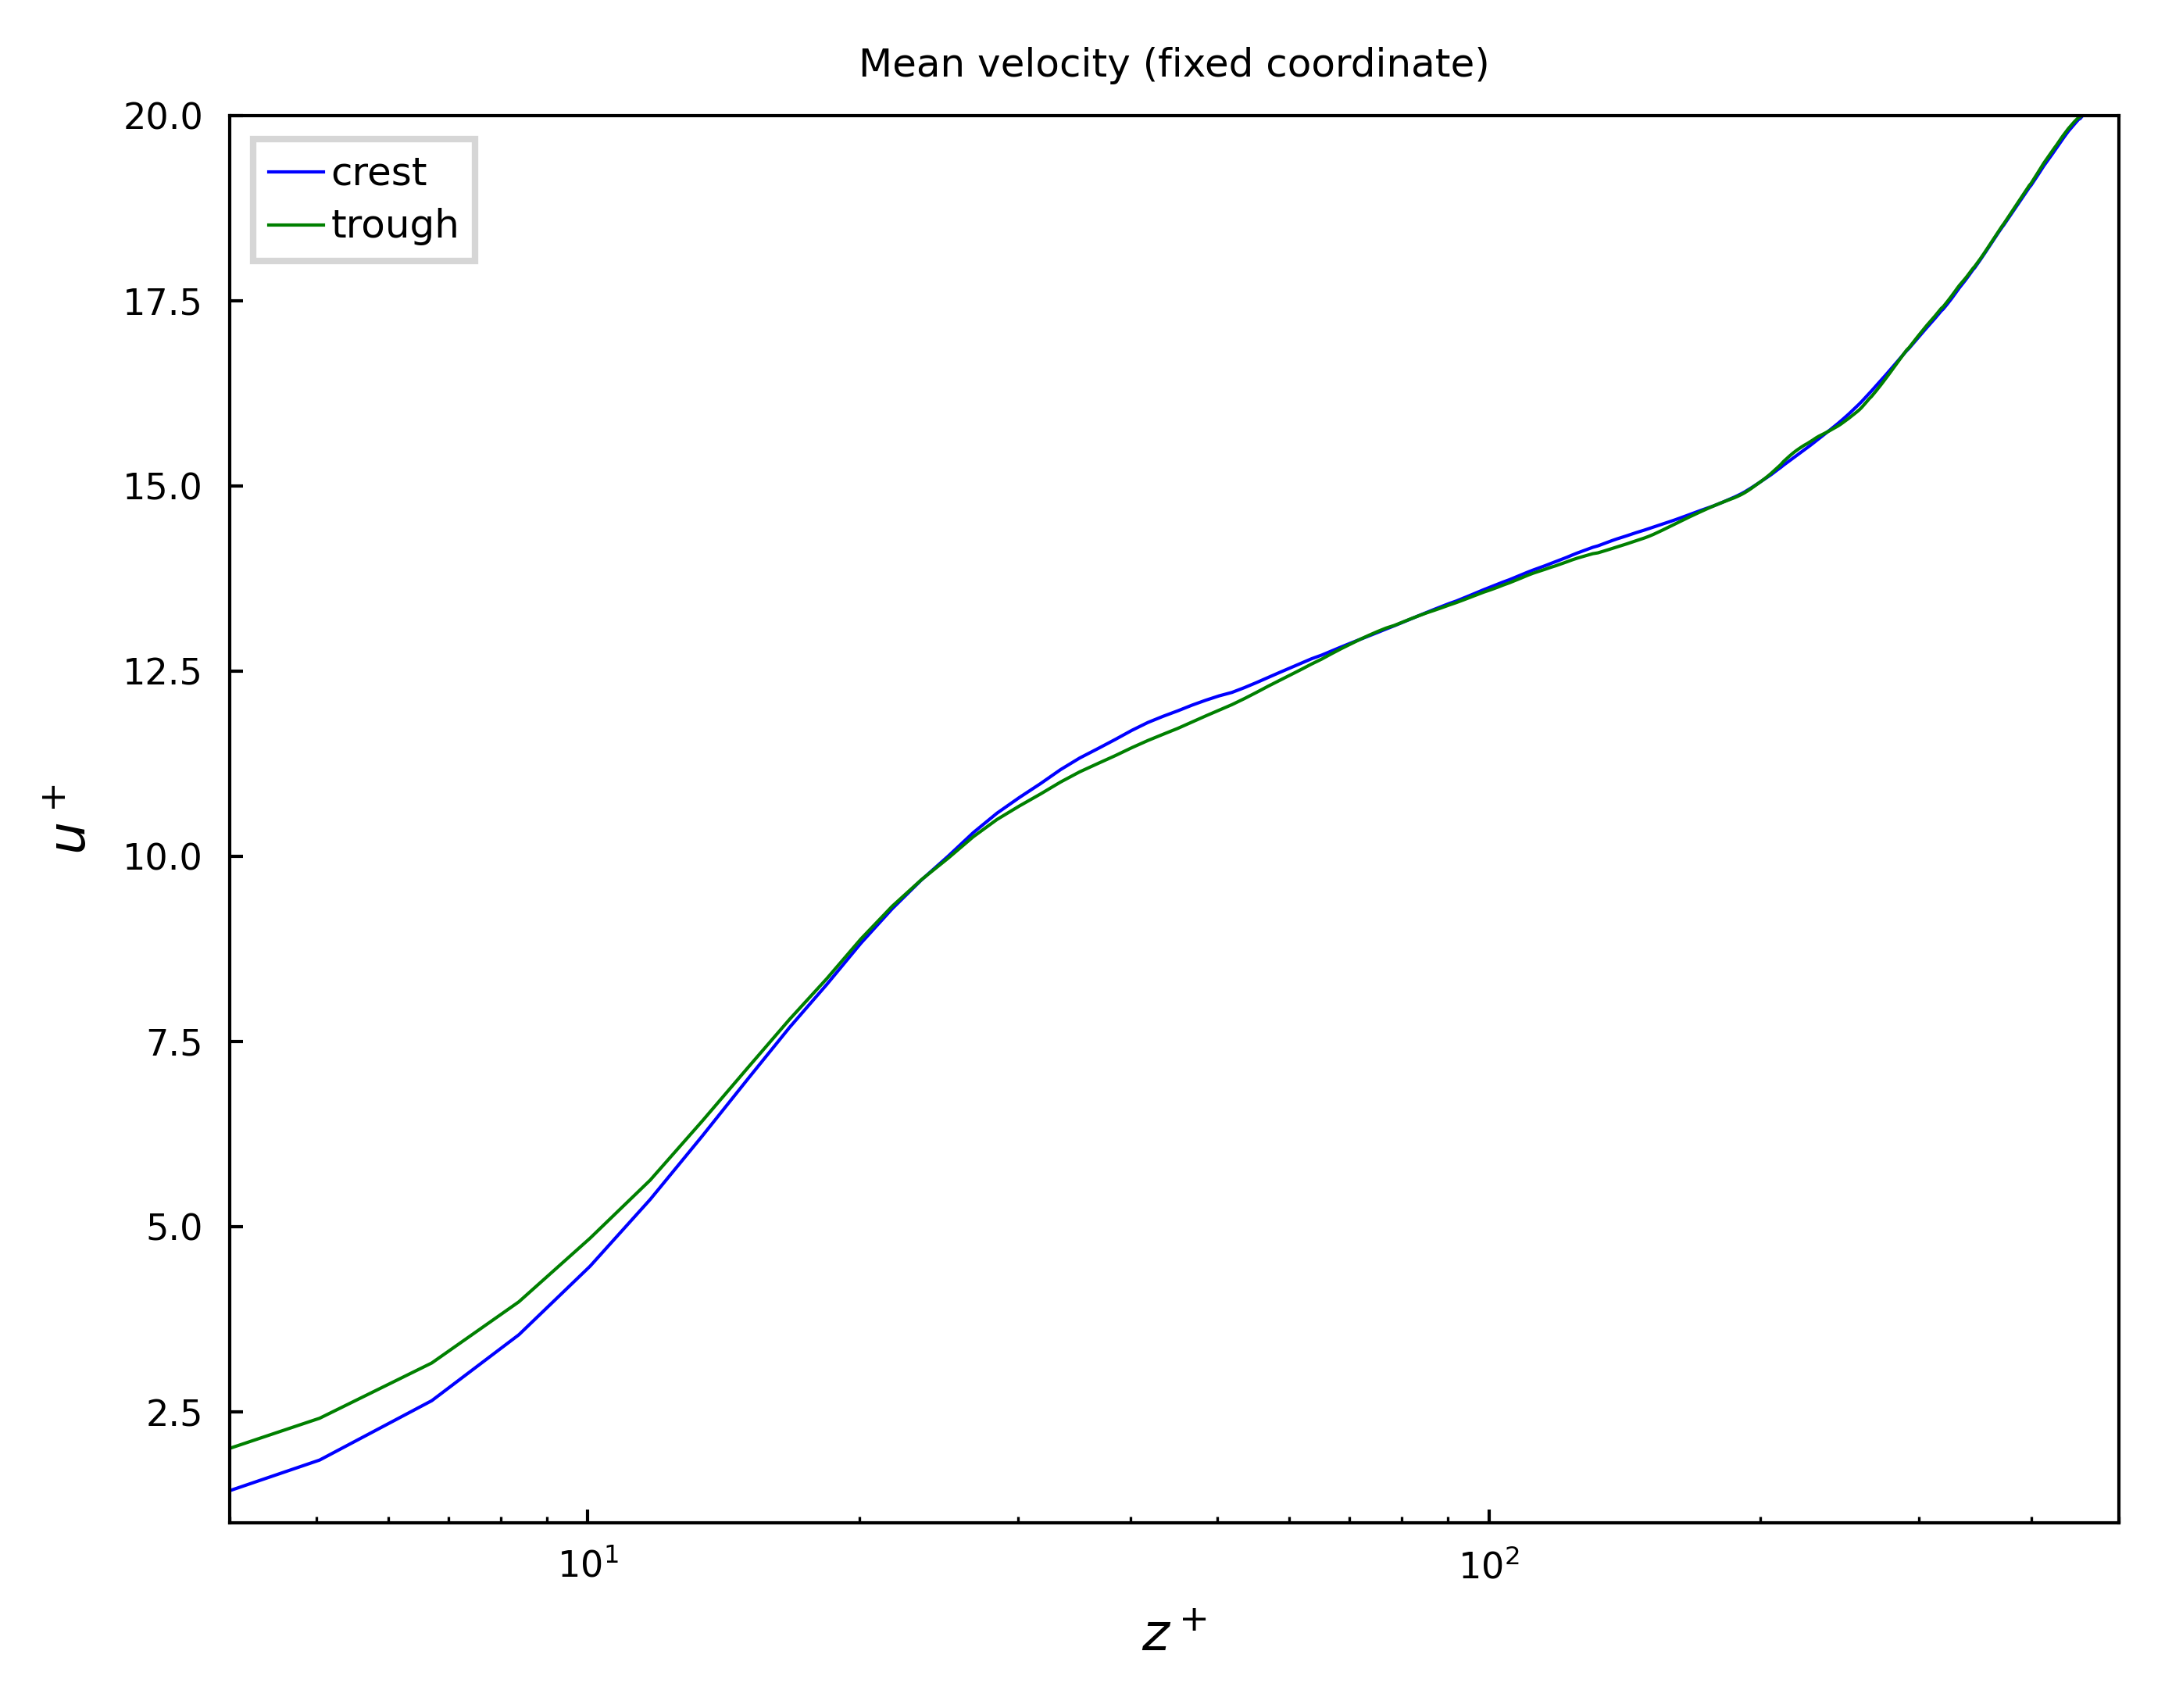

In [80]:
ds = 

zwall = (2*np.pi-1)/720
ustar = 0.25

tol = 2*np.pi/(512/4)

crest1 = ds.where(abs(ds.phase-np.pi/2)<tol,drop=True).ux.isel(t=0).mean(dim='phase')
crest2 = ds.where(abs(ds.phase-3*np.pi/2)<tol,drop=True).ux.isel(t=0).mean(dim='phase')
plt.plot((ds.y-1)/zwall, (crest1+crest2)/2/ustar, label='crest')
trough1 = ds.where(abs(ds.phase-np.pi)<tol,drop=True).ux.isel(t=0).mean(dim='phase')
trough2 = ds.where(abs(ds.phase-np.pi)<tol,drop=True).ux.isel(t=0).mean(dim='phase')
plt.plot((ds.y-1)/zwall, (trough1+trough2)/2/ustar, label='trough')

plt.xlim([4,500])
plt.ylim([1,20])
plt.xscale('log')
plt.xlabel('$z^+$'); plt.ylabel('$u^+$')
plt.title('Mean velocity (fixed coordinate)', fontsize=6)
plt.legend(fontsize=6)